# Flexible job shop
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/PyJobShop/PyJobShop/blob/main/examples/flexible_job_shop.ipynb)

> If you're using this notebook in Google Colab, be sure to install PyJobShop first by executing ```pip install pyjobshop``` in a cell.

In this notebook, we show you how to model and solve a flexible job shop problem with PyJobShop.

The Flexible Job Shop Problem (FJSP) is a commonly studied scheduling problem that generalizes many known scheduling problem variants. 
In the FJSP, there is a set of machines and a set of jobs.
Each job is composed of a sequence of tasks, which must be processed in the given sequence.
Each task needs to be processed by exactly one machine that is selected from a set of eligible machines.
The main goal of the FJSP is commonly to minimize the makespan.

## Data

Let's consider a simple example from [Google OR-Tools](https://github.com/google/or-tools/blob/master/examples/python/flexible_job_shop_sat.py). Below we have a data instance with three machines and three jobs, each job consisting of three consecutive tasks.

In [1]:
NUM_MACHINES = 3

# Each job consists of a list of tasks. A task is represented
# by a list of tuples (processing_time, machine), denoting the eligible
# machine assignments and corresponding processing times.
data = [
    [  # Job with three tasks
        [(3, 0), (1, 1), (5, 2)],  # task with three eligible machines
        [(2, 0), (4, 1)],
        [(2, 0), (3, 1)],
    ],
    [
        [(2, 0), (3, 1), (4, 2)],
        [(1, 0), (4, 2)],
        [(2, 0), (4, 2)],
    ],
    [
        [(2, 0), (1, 1), (4, 2)],
        [(3, 1), (4, 2)],
        [(1, 1), (5, 2)],
    ],
]

## Model

In [2]:
from pyjobshop import Model

m = Model()

Data objects such as machines, jobs and tasks can be created with the `Model.add_*` method.
Each task is associated with its corresponding job upon creation.

In [3]:
machines = [
    m.add_machine(name=f"Machine {idx}") for idx in range(NUM_MACHINES)
]

In [4]:
jobs = {}
tasks = {}

for job_idx, job_data in enumerate(data):
    job = m.add_job(name=f"Job {job_idx}")
    jobs[job_idx] = job

    for idx in range(len(job_data)):
        task_idx = (job_idx, idx)
        tasks[task_idx] = m.add_task(job, name=f"Task {task_idx}")

There are two more things that we need to add to the model:

- Processing times of specific task and machine combinations must be set; and
- Tasks of the same job must be processed in a given order.

In [5]:
for job_idx, job_data in enumerate(data):
    for idx, task_data in enumerate(job_data):
        task = tasks[(job_idx, idx)]

        for duration, machine_idx in task_data:
            machine = machines[machine_idx]
            m.add_mode(task, machine, duration)

    for idx in range(len(job_data) - 1):
        first = tasks[(job_idx, idx)]
        second = tasks[(job_idx, idx + 1)]
        m.add_end_before_start(first, second)

Now that we have our model setup correctly, we can solve the model.

In [6]:
result = m.solve(display=False)
print(result)

Solution results
  objective: 7.00
lower bound: 7.00
     status: Optimal
    runtime: 0.01 seconds


We found the optimal solution! Let's plot it now.

### Understanding the solution

Let's examine the optimal schedule. In the plot below, each task is labeled as `Task (j, k)` where:
- $j$ represents the job index (0, 1, or 2)
- $k$ represents the operation index within that job (0, 1, or 2 for first, second, or third operation)

For example, $T_{00}$ means the first operation of Job 0, and $T_{21}$ means the second operation of Job 2.

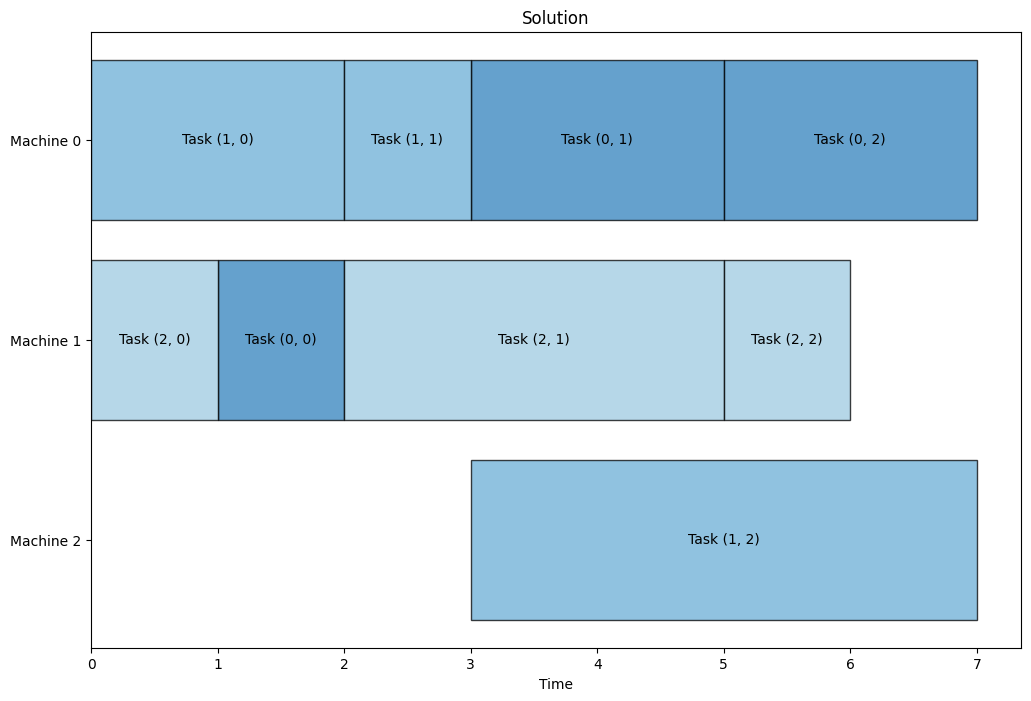

In [7]:
from pyjobshop.plot import plot_machine_gantt

plot_machine_gantt(result.best, m.data(), plot_labels=True)

From this Gantt chart, we can verify several things about the solution:

1. Job sequencing: Each job's operations are processed in the correct order (operation 0 before operation 1 before operation 2)
2. Machine assignment: Each job's operation is processed with an eligible machine based on the correct processing times

## Summary
This concludes the notebook. We showed how to set up an FJSP problem instance using PyJobShop's modeling interface. After setup, we solved the model and plotted the optimal solution.